In [224]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import sys
from pathlib import Path
import xarray as xr
import cfgrib
import cartopy.crs as ccrs  # Projeções de mapas.
import cartopy.feature as cfeature  # Elementos geográficos.
from matplotlib.tri import Triangulation

#Import local libraries
import aux

In [225]:
year='2018'
month='12'
month_abbr = datetime.datetime.strptime(month, "%m").strftime("%b")

base_dir='/pesq/dados/monan/users/madeleine.gacita/global_data/'
exp_name="CTRL"
exp_name2="land_mult_24"

In [226]:
rad_var_dict={
    "ISR": {
        "era5_name" : "ssrd",
        "era5_longname" :"surface_solar_radiation_downwards",
        "ceres_name" : "init_all_sfc_sw_dn", 
        "monan_name" : "swdnb",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    },
    "ISRC": {
        "era5_name" : "ssrdc",
        "era5_longname" :"surface_solar_radiation_downward_clear_sky",
        "ceres_name" : "init_clr_sfc_sw_dn", 
        "monan_name" : "swdnbc",
        "unit" : "W m^{-2}",
        "label" : "Surface shortwave radiation downwards (clear sky)",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    },
    "OLR": {
        "era5_name": "ttr",
        "era5_longname" :"top_net_thermal_radiation",
        "ceres_name" : "init_all_toa_lw_up", 
        "monan_name" : "lwupt",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation",
        "24vmin" : -400,
        "24vmin" : -3000,
        "24vmax" : 0,
        "24vmax" : 0
    },
    "OLRC": {
        "era5_name" : "ttrc",
        "era5_longname" : "top_net_thermal_radiation_clear_sky",
        "ceres_name" : "init_clr_toa_lw_up", 
        "monan_name" : "lwuptc",
        "unit" : "W m^{-2}",
        "label" : "TOA Outgoing longwave radiation (clear sky)",
        "vmin" : -400,
        "24vmin" : -3000,
        "vmax" : 0,
        "24vmax" : 0
    },
    "TISR": {
        "era5_name" : "tisr",
        "era5_longname" : "toa_incident_solar_radiation",
        "ceres_name" : "toa_sw_insol", 
        "monan_name" : "swdnt",
        "unit" : "W m^{-2}",
        "label" : "TOA incident short-wave (solar) radiation",
        "vmin" : 0,
        "24vmin" : 0,
        "vmax" : 1300,
        "24vmax" : 8000
    }
}

surf_flux_dict={
    "HF": {
        "era5_name" : "sshf",
        "era5_longname" : "surface_sensible_heat_flux",
        "monan_name" : "hfx", 
        "unit" : "W/m**2",
        "label" : "Sensible heat flux"
    },
    "LF": {
        "era5_name": "sslf",
        "era5_longname":"surface_latent_heat_flux",
        "monan_name": "lf", 
        "unit": "W m^{-2}",
        "label": "Latent heat flux"
    }
}

profile_vars_dict={
    "ISR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_dn",
        "unit" : "W m^{-2}",
        "label" : "Incoming shortwave radiation"
    },
    "OSR": {
        "monan_name" : "ssrd",
        "ceres_name" : "adj_all_sw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing shortwave radiation"
    },
    "ILR": {
        "monan_name" : "ttrc",
        "ceres_name" : "adj_all_lw_dn", 
        "unit" : "W m^{-2}",
        "label" : "Incoming longwave radiation"
    },
    "OLR": {
        "monan_name" : "ttr",
        "ceres_name" : "adj_all_lw_up", 
        "unit" : "W m^{-2}",
        "label" : "Outgoing longwave radiation"
    }    
}

In [227]:
def apply_lon_lat_conventions(ds):
    # Renames
    if "lon" in ds.dims:
        ds = ds.rename({"lon": "longitude"})
    if "lat" in ds.dims:
        ds = ds.rename({"lat": "latitude"})
 
    # Flip latitudes (ensure they are monotonic increasing)
    if "latitude" in ds.dims:
        lats = ds["latitude"]
        if len(lats) > 1 and lats[0] > lats[-1]:
            ds = ds.reindex(latitude=ds.latitude[::-1])
 
    # Convert longitude to [-180, 180[
    if "longitude" in ds.dims and ds["longitude"].max() > 180:
        lons = ds["longitude"]
        lons_attrs = lons.attrs
        new_lons = np.concatenate([lons[lons >= 180], lons[lons < 180]])
        ds = ds.reindex(longitude=new_lons)
        ds = ds.assign_coords(longitude=(((ds["longitude"] + 180) % 360) - 180))
        ds["longitude"].attrs = lons_attrs
    return ds

# Opening CERES SYN_1deg Ed A

In [228]:
syn_file_arg = base_dir+"CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406."+year+month+".hdf"
path = Path(syn_file_arg)
print(syn_file_arg)

if not path.exists():
    print(f"File does not exist: {path!s}")
else:
    from pyhdf.SD import SD, SDC
    sd = SD(str(path), SDC.READ)
    print("pyhdf.SD opened file — datasets:")
    names = list(sd.datasets().keys())


/pesq/dados/monan/users/madeleine.gacita/global_data/CER_SYN1deg-MHour/Terra-Aqua-MODIS_Edition4A/CER_SYN1deg-MHour_Terra-Aqua-MODIS_Edition4A_407406.201812.hdf
pyhdf.SD opened file — datasets:


# Radiation

### Plots general settings

In [229]:
var="ISR"
flux_var_name = f'{rad_var_dict[var]["era5_name"]}_flux'
fig_path="/pesq/dados/monan/users/madeleine.gacita/figuras_rodada/"

UTC_hour_plot=15
target_lon = -60.0

## Opening MONAN data and extracting {var}

In [230]:
monan_dir=f"/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/{exp_name}/derived_data/"

# monan_diag=f"MONAN_DIAG_G_MOD_GFS_2018111500_{year}{month}{day}{hour}.00.00.x655362L55.nc"
monan_file=f'{monan_dir}/{month_abbr}{year}_hourly_{rad_var_dict[var]["monan_name"]}_MHourly.nc'

monan_path = Path(monan_file)

ds_monan = xr.open_dataset(monan_path, engine="h5netcdf")
# Adjusting sign of OLR / OLRC as negative outgoing
if var=="OLR" or var=="OLRC":
    ds_monan[rad_var_dict[var]['monan_name']] = 0 - ds_monan[rad_var_dict[var]['monan_name']]


monan_lons=ds_monan['lon']
monan_lats=ds_monan['lat']

print(ds_monan)

<xarray.Dataset> Size: 199MB
Dimensions:     (hour: 24, nCells: 655362)
Coordinates:
  * hour        (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    lat         (nCells) float64 5MB ...
    lon         (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    local_hour  (hour, nCells) timedelta64[ns] 126MB ...
    swdnb       (hour, nCells) float32 63MB ...


/tmp/ipykernel_3479587/1701823807.py:8: FutureWarning: In a future version, xarray will not decode the variable 'local_hour' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds_monan = xr.open_dataset(monan_path, engine="h5netcdf")


In [260]:
monan_dir2=f"/pesq/dados/monan/users/lianet.hernandez/global_clm_2018-2019/{exp_name2}/derived_data/"

# monan_diag=f"MONAN_DIAG_G_MOD_GFS_2018111500_{year}{month}{day}{hour}.00.00.x655362L55.nc"
monan_file2=f'{monan_dir2}/{month_abbr}{year}_hourly_{rad_var_dict[var]["monan_name"]}_MHourly.nc'

monan_path2 = Path(monan_file2)

ds_monan2 = xr.open_dataset(monan_path2, engine="h5netcdf")
# Adjusting sign of OLR / OLRC as negative outgoing
if var=="OLR" or var=="OLRC":
    ds_monan2[rad_var_dict[var]['monan_name']] = 0 - ds_monan2[rad_var_dict[var]['monan_name']]


monan_lons=ds_monan['lon']
monan_lats=ds_monan['lat']

print(ds_monan2)

<xarray.Dataset> Size: 199MB
Dimensions:     (hour: 24, nCells: 655362)
Coordinates:
  * hour        (hour) int32 96B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23
    lat         (nCells) float64 5MB ...
    lon         (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Data variables:
    swdnb       (hour, nCells) float32 63MB ...
    local_hour  (hour, nCells) timedelta64[ns] 126MB ...


/tmp/ipykernel_3479587/3420547328.py:8: FutureWarning: In a future version, xarray will not decode the variable 'local_hour' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  ds_monan2 = xr.open_dataset(monan_path2, engine="h5netcdf")


### Plotting for {UTC_hour_plot}

In [261]:
monan_data_sel_time = ds_monan[rad_var_dict[var]['monan_name']].where(ds_monan['hour'] == UTC_hour_plot, drop=True)[0]

monan_data_sel_time2 = ds_monan2[rad_var_dict[var]['monan_name']].where(ds_monan2['hour'] == UTC_hour_plot, drop=True)[0]

print(monan_data_sel_time2)

<xarray.DataArray 'swdnb' (nCells: 655362)> Size: 3MB
array([  0.     , 116.99911,   0.     , ...,   0.     ,   0.     ,
         0.     ], shape=(655362,), dtype=float32)
Coordinates:
    hour     int32 4B 15
    lat      (nCells) float64 5MB ...
    lon      (nCells) float64 5MB ...
Dimensions without coordinates: nCells
Attributes:
    units:        W m^{-2}
    long_name:    Monthly Hourly Mean swdnb
    description:  Diurnal cycle: mean for each hour (0-23 UTC) averaged over ...


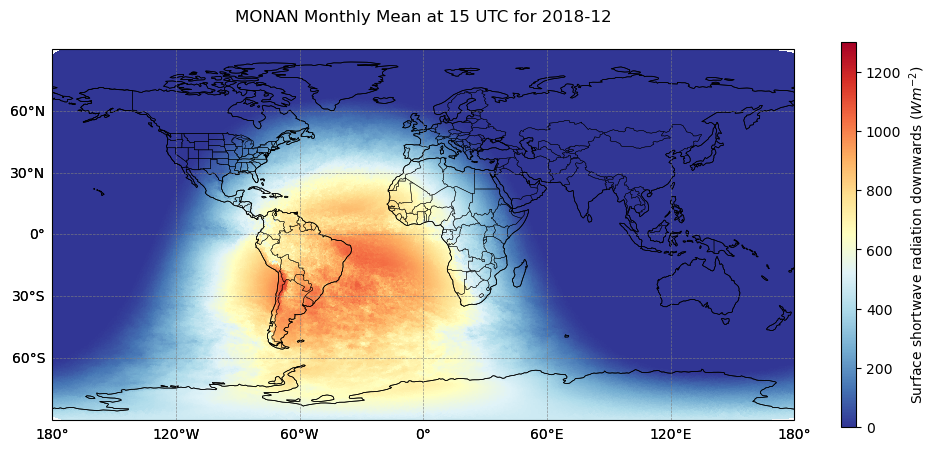

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_15_CTRL.png


In [233]:
# Create triangulation
tri = Triangulation(monan_lons, monan_lats)


    
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_sel_time, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax']
    )
plt.colorbar(tpc, label= f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_{UTC_hour_plot}_{exp_name}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

### Plotting 24h accumulated

In [262]:
monan_data_accum = ds_monan[rad_var_dict[var]['monan_name']].sum(dim='hour')
monan_data_accum2 = ds_monan2[rad_var_dict[var]['monan_name']].sum(dim='hour')
print(monan_data_accum.values.min())
print(monan_data_accum.values.max())

0.0
11516.714


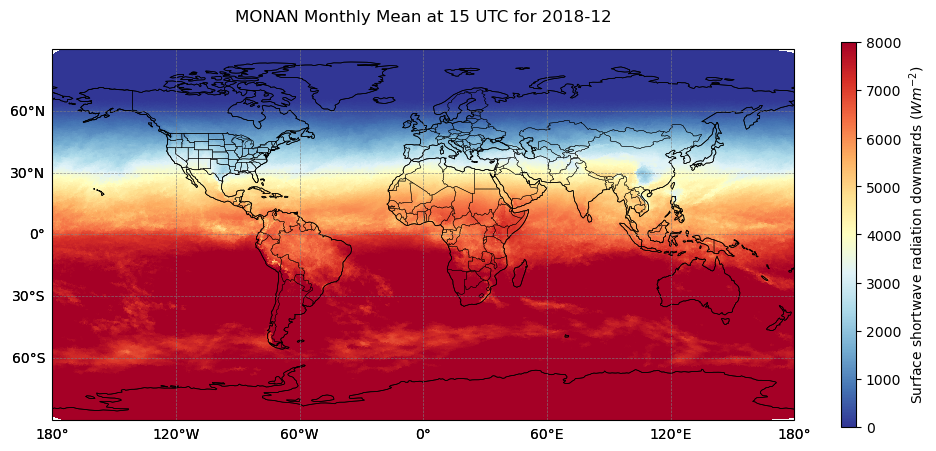

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//MONAN_ISR_2018_12_24accum_CTRL.png


In [235]:
# Plot using coordinates; try to orient lat/lon if dimensions suggest it
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Plot
tpc = ax.tripcolor(
    tri, monan_data_accum, 
    cmap="RdYlBu_r", 
    shading="flat",
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax']
    )
plt.colorbar(tpc, label= f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)", shrink= 0.5, aspect = 25, pad = 0.05)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"MONAN Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

plt.tight_layout()
out_png = f"{fig_path}/MONAN_{var}_{year}_{month}_24accum_{exp_name}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

## Extracting CERES {var} data from opened file

In [236]:
ceres_var_name = rad_var_dict[var]['ceres_name']
print(f"Reading dataset: {ceres_var_name}")
sds = sd.select(ceres_var_name)
CER_data = sds.get()              
print(f"{sds.info()}") # shows name, rank, dims, type
dims = sds.info()[2]

#     # Apply scale/offset if present in attributes
attrs = sds.attributes()

scale = attrs.get('scale_factor') or attrs.get('scale') or attrs.get('SCALE')
offset = attrs.get('add_offset') or attrs.get('offset') or attrs.get('OFFSET')
fillvalue  = attrs.get('fill_value') or attrs.get('_FillValue')
datamin,datamax = attrs.get('valid_range')
unit = attrs.get('units')

if scale is not None:
    CER_data = CER_data * float(scale)
if offset is not None:
    CER_data = CER_data + float(offset)
CER_data_masked = np.where(CER_data < datamax, CER_data, np.nan) 

if unit == "cm":
    # converting to kg/m2
    CER_data_masked = CER_data_masked * 10
elif unit == "g m-2":
    # converting to kg/m2
    CER_data_masked = CER_data_masked / 1000

# Find longitude and latitude coordinates for georeferenced plotting
lon_coords = None
lat_coords = None
lon_names = [n for n in names if 'lon' in n.lower() or 'longitude' in n.lower()]
for lname in lon_names:
    try:
        lds = sd.select(lname)
        try:
            lvals = lds.get()
        except Exception:
            lvals = lds[:]
        lon_coords = np.array(lvals)
        try:
            lds.end()
        except Exception:
            pass
        break
    except Exception:
        continue
lat_names = [n for n in names if 'lat' in n.lower() or 'latitude' in n.lower()]
for lname in lat_names:
    try:
        lds = sd.select(lname)
        try:
            lvals = lds.get()
        except Exception:
            lvals = lds[:]
        lat_coords = np.array(lvals)
        try:
            lds.end()
        except Exception:
            pass
        break
    except Exception:
        continue

#     Getting GMT time
hour_data = sd.select('gmt_hr_index').get()

if (len(dims)>3 and 5 in dims):      
#     We have a cloud layer dim
    cld_index = sd.select('cloud_layer').get()


# # Creating Xarray
if (len(dims)>3 and 5 in dims):      
#     Have a cloud layer dim
    if "CER_data_xa" in locals() and isinstance(locals()["CER_data_xa"], xr.Dataset):
        print(f'Adding {ceres_var_name} to dataArray')
        CER_data_xa[ceres_var_name] = (("cloud_layer","gmt_hr_index", "lat", "lon"), CER_data_masked)
    else:
        print('Creating DataSet')
        CER_data_xa = xr.Dataset(
            {
                ceres_var_name: (("cloud_layer", "gmt_hr_index", "lat", "lon"), CER_data_masked)
            },
            coords={
                "cloud_layer": cld_index,
                "gmt_hr_index": hour_data,
                "lat": lat_coords,
                "lon": lon_coords,
            }
        )
else:
#     Have a cloud layer dim
    if "CER_data_xa" in locals() and isinstance(locals()["CER_data_xa"], xr.Dataset):
        print(f'Adding {ceres_var_name} to dataArray')
        CER_data_xa[ceres_var_name] = (("gmt_hr_index", "lat", "lon"), CER_data_masked)
    else:
        print('Creating DataSet')
        CER_data_xa = xr.Dataset(
            {
                ceres_var_name: (( "gmt_hr_index", "lat", "lon"), CER_data_masked)
            },
            coords={
                "gmt_hr_index": hour_data,
                "lat": lat_coords,
                "lon": lon_coords,
            }
        )

# Adjusting sign of OLR / OLRC as negative outgoing
if var=="OLR" or var=="OLRC":
    CER_data_xa[ceres_var_name] = 0 - CER_data_xa[ceres_var_name]

utc_hours = CER_data_xa['gmt_hr_index'].values   # shape (24,)
lon = CER_data_xa['lon'].values                  # shape (360,)

# Longitude offset in hours
lon_offset_hours = lon / 15.0

# Broadcast to (gmt_hr_index, lon)
local_hour = (utc_hours[:, None] + lon_offset_hours[None, :]) % 24
local_hour = local_hour.astype(int)

# Assign as coordinate
CER_data_xa = CER_data_xa.assign_coords(local_hour=(("gmt_hr_index", "lon"), local_hour))

Reading dataset: init_all_sfc_sw_dn
('init_all_sfc_sw_dn', 3, [24, 180, 360], 5, 5)
Adding init_all_sfc_sw_dn to dataArray


## Plotting CERES {var} data at {UTC_hour_plot}

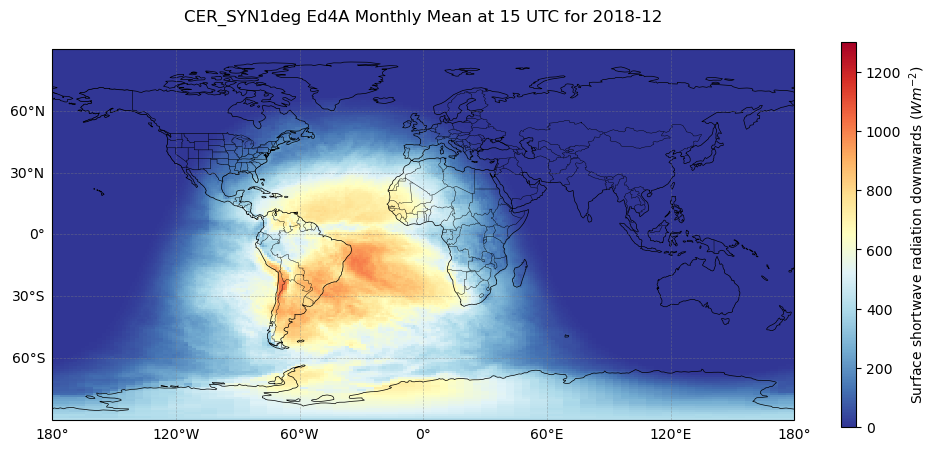

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_15.png


In [237]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

CER_data_sel_time = CER_data_xa.where(CER_data_xa['gmt_hr_index'] == UTC_hour_plot, drop=True)

# Plot the data (sorted by latitude to avoid ValueError)
im = CER_data_sel_time[ceres_var_name].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")

#### Plotting CERES {var} 24 h accum data 

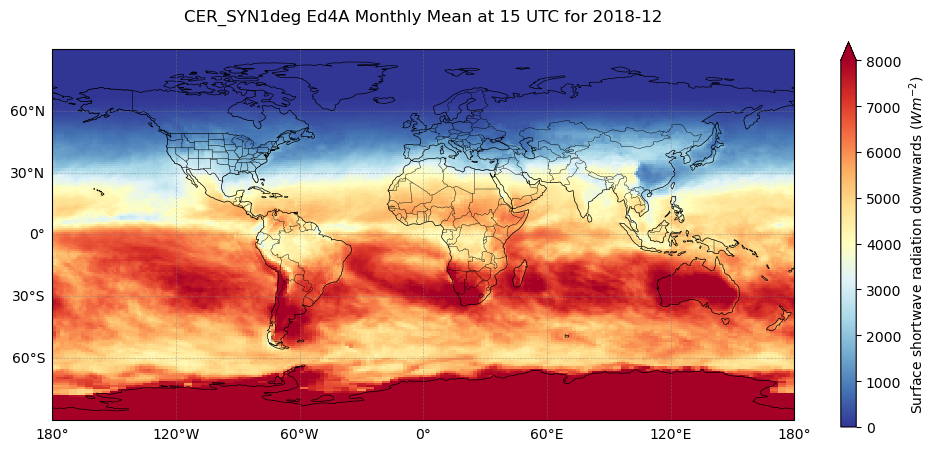

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//CER_SYN1deg_Ed4A_ISR_2018_12_24accum.png


In [238]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

CER_data_all_time = CER_data_xa[ceres_var_name].sum(dim='gmt_hr_index')

# Plot the data (sorted by latitude to avoid ValueError)
im = CER_data_all_time.plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.set_title(f"CER_SYN1deg Ed4A Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/CER_SYN1deg_Ed4A_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved plot to: {out_png}")




## Opening ERA5 {var} data

In [239]:
era5_file_arg = base_dir+f"era5/single_levels/{year}/{month}/{rad_var_dict[var]['era5_longname']}_MHour.nc"
path = Path(era5_file_arg)

ds_era5 = xr.open_dataset(path, engine="netcdf4")
ds_era5 = apply_lon_lat_conventions(ds_era5)

ds_era5[flux_var_name] = ds_era5[rad_var_dict[var]["era5_name"]]/3600
ds_era5[flux_var_name].attrs = {'units': rad_var_dict[var]["unit"]}
ds_era5[flux_var_name].attrs['description'] = f'Instantaneous flux calculated from accumulated {rad_var_dict[var]["era5_name"].upper()}'
print(ds_era5[flux_var_name].attrs)
print(ds_era5['valid_time'])


{'units': 'W m^{-2}', 'description': 'Instantaneous flux calculated from accumulated SSRD'}
<xarray.DataArray 'valid_time' (valid_time: 24)> Size: 192B
array(['2018-12-01T01:00:00.000000000', '2018-12-01T02:00:00.000000000',
       '2018-12-01T03:00:00.000000000', '2018-12-01T04:00:00.000000000',
       '2018-12-01T05:00:00.000000000', '2018-12-01T06:00:00.000000000',
       '2018-12-01T07:00:00.000000000', '2018-12-01T08:00:00.000000000',
       '2018-12-01T09:00:00.000000000', '2018-12-01T10:00:00.000000000',
       '2018-12-01T11:00:00.000000000', '2018-12-01T12:00:00.000000000',
       '2018-12-01T13:00:00.000000000', '2018-12-01T14:00:00.000000000',
       '2018-12-01T15:00:00.000000000', '2018-12-01T16:00:00.000000000',
       '2018-12-01T17:00:00.000000000', '2018-12-01T18:00:00.000000000',
       '2018-12-01T19:00:00.000000000', '2018-12-01T20:00:00.000000000',
       '2018-12-01T21:00:00.000000000', '2018-12-01T22:00:00.000000000',
       '2018-12-01T23:00:00.000000000', '2018

## Plotting ERA5 {var} data at {UTC_hour_plot}

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_15.png


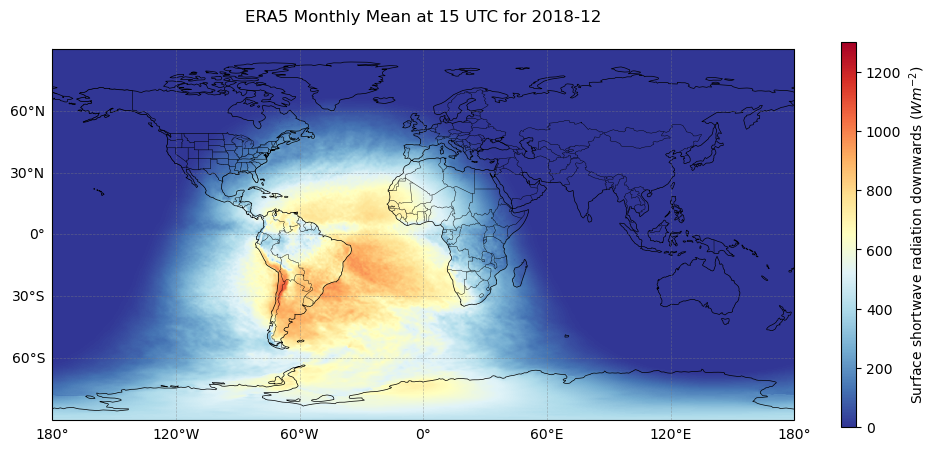

In [240]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_sel_time = ds_era5.where(ds_era5['valid_time'].dt.hour == UTC_hour_plot, drop=True)

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_sel_time[flux_var_name].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['vmin'],
    vmax=rad_var_dict[var]['vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_{UTC_hour_plot}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Plotting ERA5 {var} 24 h accum data

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ERA5_ISR_2018_12_24accum.png


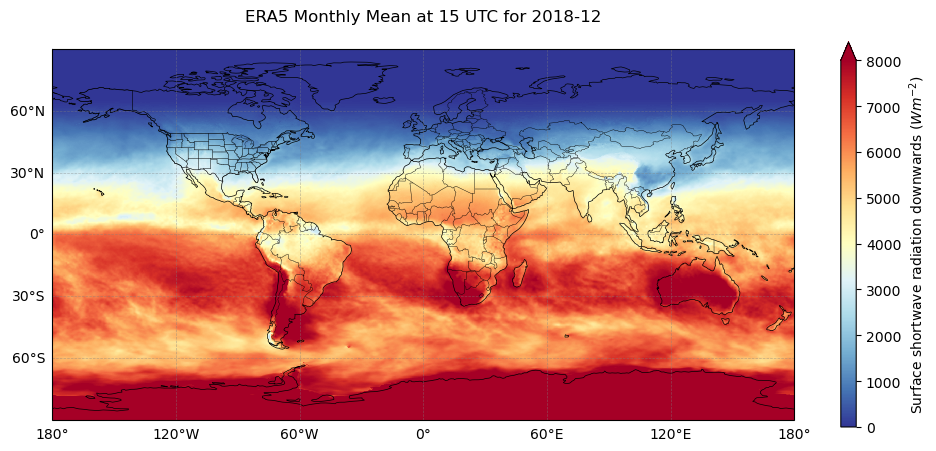

In [241]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

ds_era5_all_time = ds_era5.sum(dim='valid_time')

# Plot the data (sorted by latitude to avoid ValueError)
im = ds_era5_all_time[flux_var_name].plot(
    ax=ax, 
    cmap='RdYlBu_r',
    vmin=rad_var_dict[var]['24vmin'],
    vmax=rad_var_dict[var]['24vmax'],
    cbar_kwargs={
        'shrink': 0.5,  # Make colorbar 70% of the plot height
        'aspect': 25,   # Control width (higher = thinner)
        'pad': 0.05,    # Space between plot and colorbar
        'label': f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']}$)"
    }
)

# Add geographic features
ax.coastlines(linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.STATES, linewidth=0.2)

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# Set title
ax.set_title(f"ERA5 Monthly Mean at {UTC_hour_plot} UTC for {year}-{month}", fontsize=12, pad=20)

plt.tight_layout()
out_png = f"{fig_path}/ERA5_{var}_{year}_{month}_24accum.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')

print(f"Saved plot to: {out_png}")

## Plotting profile at {UTC_hour_plot} and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [242]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_sel_time

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice[flux_var_name].values[0]

In [243]:
print(era5_lat)
print(era5_values)

[-90.   -89.75 -89.5  -89.25 -89.   -88.75 -88.5  -88.25 -88.   -87.75
 -87.5  -87.25 -87.   -86.75 -86.5  -86.25 -86.   -85.75 -85.5  -85.25
 -85.   -84.75 -84.5  -84.25 -84.   -83.75 -83.5  -83.25 -83.   -82.75
 -82.5  -82.25 -82.   -81.75 -81.5  -81.25 -81.   -80.75 -80.5  -80.25
 -80.   -79.75 -79.5  -79.25 -79.   -78.75 -78.5  -78.25 -78.   -77.75
 -77.5  -77.25 -77.   -76.75 -76.5  -76.25 -76.   -75.75 -75.5  -75.25
 -75.   -74.75 -74.5  -74.25 -74.   -73.75 -73.5  -73.25 -73.   -72.75
 -72.5  -72.25 -72.   -71.75 -71.5  -71.25 -71.   -70.75 -70.5  -70.25
 -70.   -69.75 -69.5  -69.25 -69.   -68.75 -68.5  -68.25 -68.   -67.75
 -67.5  -67.25 -67.   -66.75 -66.5  -66.25 -66.   -65.75 -65.5  -65.25
 -65.   -64.75 -64.5  -64.25 -64.   -63.75 -63.5  -63.25 -63.   -62.75
 -62.5  -62.25 -62.   -61.75 -61.5  -61.25 -61.   -60.75 -60.5  -60.25
 -60.   -59.75 -59.5  -59.25 -59.   -58.75 -58.5  -58.25 -58.   -57.75
 -57.5  -57.25 -57.   -56.75 -56.5  -56.25 -56.   -55.75 -55.5  -55.25
 -55. 

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [244]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_sel_time

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d.isel(lon=ceres_lon_idx)
ceres_lat = ceres_slice['lat'].values
ceres_values = ceres_slice[ceres_var_name].values[0]

In [245]:
print(ceres_lat)
print(ceres_values)

[ 89.5  88.5  87.5  86.5  85.5  84.5  83.5  82.5  81.5  80.5  79.5  78.5
  77.5  76.5  75.5  74.5  73.5  72.5  71.5  70.5  69.5  68.5  67.5  66.5
  65.5  64.5  63.5  62.5  61.5  60.5  59.5  58.5  57.5  56.5  55.5  54.5
  53.5  52.5  51.5  50.5  49.5  48.5  47.5  46.5  45.5  44.5  43.5  42.5
  41.5  40.5  39.5  38.5  37.5  36.5  35.5  34.5  33.5  32.5  31.5  30.5
  29.5  28.5  27.5  26.5  25.5  24.5  23.5  22.5  21.5  20.5  19.5  18.5
  17.5  16.5  15.5  14.5  13.5  12.5  11.5  10.5   9.5   8.5   7.5   6.5
   5.5   4.5   3.5   2.5   1.5   0.5  -0.5  -1.5  -2.5  -3.5  -4.5  -5.5
  -6.5  -7.5  -8.5  -9.5 -10.5 -11.5 -12.5 -13.5 -14.5 -15.5 -16.5 -17.5
 -18.5 -19.5 -20.5 -21.5 -22.5 -23.5 -24.5 -25.5 -26.5 -27.5 -28.5 -29.5
 -30.5 -31.5 -32.5 -33.5 -34.5 -35.5 -36.5 -37.5 -38.5 -39.5 -40.5 -41.5
 -42.5 -43.5 -44.5 -45.5 -46.5 -47.5 -48.5 -49.5 -50.5 -51.5 -52.5 -53.5
 -54.5 -55.5 -56.5 -57.5 -58.5 -59.5 -60.5 -61.5 -62.5 -63.5 -64.5 -65.5
 -66.5 -67.5 -68.5 -69.5 -70.5 -71.5 -72.5 -73.5 -7

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [264]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_sel_time

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


In [265]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d_2 =monan_data_sel_time2

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice_2 = monan_lats[mask]
monan_slice_2 = monan_data_2d_2[mask]

# Order by latitude
order = np.argsort(monan_lat_slice_2)
monan_lat_slice_sorted2 = monan_lat_slice_2[order]
monan_slice_sorted2 = monan_slice_2[order]

### Create the plot

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ISR_201812_15UTC_lon-60.png


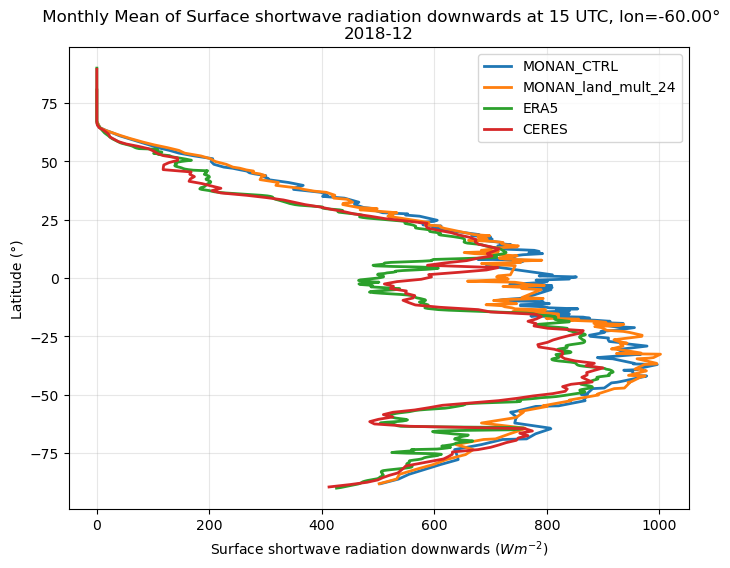

In [266]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN_{exp_name}", linewidth=2)
plt.plot(monan_slice_sorted2 ,monan_lat_slice_sorted2, label=f"MONAN_{exp_name2}", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, ceres_lat, label=f"CERES", linewidth=2)
plt.xlabel(f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {rad_var_dict[var]['label']} at {UTC_hour_plot} UTC, lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_{UTC_hour_plot}UTC_lon{int(actual_lon)}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

## Plotting profile for 24h accum and {target_lon}

### Extract ERA5 Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from ERA5
# Get the data variable at hour {UTC_hour_plot}
era5_data_2d = ds_era5_all_time[flux_var_name]

# Find longitude index closest to target_lon
era5_lon = era5_data_2d['longitude'].values
era5_lon_idx = np.argmin(np.abs(era5_lon - target_lon))
actual_lon = era5_lon[era5_lon_idx]

# Extract slice at that longitude
era5_slice = era5_data_2d.isel(longitude=era5_lon_idx)
era5_lat = era5_slice['latitude'].values
era5_values = era5_slice.values

### Extract CERES Mhourly mean data  at {UTC_hour_plot} and {target_lon} 

In [ ]:
# Get the data variable at hour {UTC_hour_plot}
ceres_data_2d = CER_data_all_time

# Find longitude index closest to target_lon
ceres_lon_idx = np.argmin(np.abs(lon_coords - target_lon))
actual_ceres_lon = lon_coords[ceres_lon_idx]        

# Extract slice at that longitude
ceres_slice = ceres_data_2d[:,ceres_lon_idx]
ceres_values = ceres_slice

### Extract MONAN Mhourly mean data at {UTC_hour_plot} and {target_lon} 

In [ ]:
#Extract data from CER_CYN1deg        
# Get the data variable at hour {UTC_hour_plot}
monan_data_2d =monan_data_accum

# Select longitude = {target_lon} (nearest index)
tol=0.05
mask = np.abs(monan_lons - target_lon) < tol
monan_lat_slice = monan_lats[mask]
monan_slice = monan_data_2d[mask]

# Order by latitude
order = np.argsort(monan_lat_slice)
monan_lat_slice_sorted = monan_lat_slice[order]
monan_slice_sorted = monan_slice[order]


### Create the plot

Saved plot to: /pesq/dados/monan/users/madeleine.gacita/figuras_rodada//ISR_201812_24_accum_lon-60_CTRL.png


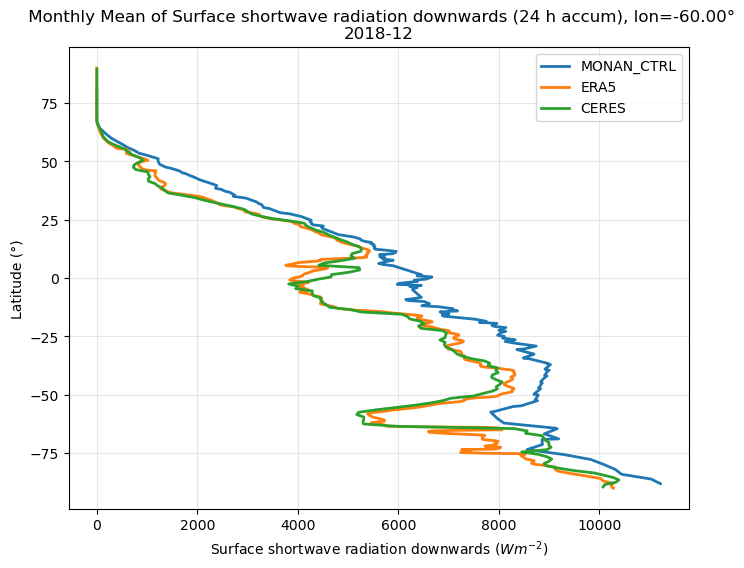

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(monan_slice_sorted ,monan_lat_slice_sorted, label=f"MONAN_{exp_name}", linewidth=2)
plt.plot(era5_values, era5_lat, label=f"ERA5", linewidth=2)
plt.plot(ceres_values, lat_coords, label=f"CERES", linewidth=2)
plt.xlabel(f"{rad_var_dict[var]['label']} (${rad_var_dict[var]['unit']})$")
plt.ylabel('Latitude (°)')
plt.title(f" Monthly Mean of {rad_var_dict[var]['label']} (24 h accum), lon={actual_lon:.2f}°\n{year}-{month}")
plt.grid(True, alpha=0.3)
plt.legend()

# Save the plot
out_png = f"{fig_path}/{var}_{year}{month}_24_accum_lon{int(actual_lon)}_{exp_name}.png"
plt.savefig(out_png, dpi=150, bbox_inches='tight')
print(f"Saved plot to: {out_png}")
plt.show()
plt.close()

### Closing MONAN and ERA5 files

In [ ]:
ds_monan.close()
ds_era5.close()

### Closing CERES file

In [ ]:
try:
    sd.end()
except Exception:
    pass